# Team Benchmark: Marissa Draft 1

**Authors:** Marissa Nicole Esteban, Gabe Krishnadasan, Diana Montoya-Herrera, Gabe Seidl, Madeleine Woo

**Date:** 11/12/2023

**Goals:** Looking at how to use seebouy data to access the NDBC.  Working on how to clean the data.

## Table of Contents:
* [Data Importing and Pre-processing](#data-importing)
* [Data Analysis and Visualization](#data-vis)
* [Data Analytics](#data-analytics)

## Data Importing and Pre-processing <a class="anchor" id="data-importing"></a>

In [9]:
# import libraries needed
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm, skew, probplot
from scipy.special import boxcox1p
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 

In [5]:
from seebuoy import NDBC

ndbc = NDBC()

# Information on NDBC's ~1800 buoys and gliders
df_buoys = ndbc.stations()

# subset to buoys around NY
# TODO: look around NTY, NJ, Maryland, and MA
m = df_buoys["closest_state"] == "New York"

df_ny = df_buoys[m]
print(df_ny.shape)
df_ny.head(2)

(43, 18)


,station_id,owner,ttype,hull,name,payload,location,timezone,forecast,note,lat_lon,lat,lon,closest_city,closest_state,ownercode,ownername,countrycode
322,44022,Y,Moored Buoy,NaN,Execution Rocks,NaN,"40.883 N 73.728 W (40&#176;53'0"" N 73&#176;43'...",E,FZUS51.KOKX,NaN,40.883 N 73.728 W,40.883,-73.728,New Rochelle,New York,Y,MYSOUND,US
325,44025,N,3-meter foam buoy,3DV24,"LONG ISLAND - 30 NM South of Islip, NY",SCOOP payload,"40.251 N 73.164 W (40&#176;15'3"" N 73&#176;9'5...",E,FZNT21.KWBC FZUS51.KOKX,Right whales are active off NY from November t...,40.251 N 73.164 W,40.251,-73.164,Freeport,New York,N,NDBC,US


#### Get available data for each buoy station near NY

I'm thinking in the future, maybe we can filter by coordinates? These could be some sort of input value.


In [7]:
df_available = ndbc.available_data(dataset="all")

# subset down to ny stations
m = df_available["station_id"].isin(df_ny["station_id"])
df_ny_avail = df_available[m] # using the mask

print(df_ny_avail.shape)
df_ny_avail.head(2)


(34, 10)


,file_name,last_modified,size,description,station_id,dataset_code,dataset,url,txt_url,timeframe
529,44022.txt,2023-11-12 19:40,314K,Standard Meteorological Data,44022,txt,standard,realtime2/44022.txt,https://www.ndbc.noaa.gov/data/realtime2/44022...,real_time
530,44025.data_spec,2023-11-12 19:20,1.4M,Raw Spectral Wave Data,44025,data_spec,spectral_summary,realtime2/44025.data_spec,https://www.ndbc.noaa.gov/data/realtime2/44025...,real_time


In [15]:
piv_ny = pd.pivot_table(
    df_ny_avail, 
    index="station_id", 
    columns="dataset", 
    aggfunc=len, 
    values="file_name"
)

piv_ny.fillna('-')


dataset,oceanographic,raw_spectral,spectral_alpha1,spectral_alpha2,spectral_r1,spectral_r2,spectral_summary,standard,supplemental
station_id,,,,,,,,,
44022,-,-,-,-,-,-,-,1.0,-
44025,-,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-
44065,-,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
44069,1.0,-,-,-,-,-,-,1.0,-
45012,-,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
45135,-,-,-,-,-,-,-,1.0,-
45137,-,-,-,-,-,-,-,1.0,-
45139,-,-,-,-,-,-,-,1.0,-
45142,-,-,-,-,-,-,-,1.0,-


In [33]:
# getting a list of all of the station_ids near NY
ny_station_ids = piv_ny.index.tolist()
print("Number of stations around NY: ", len(ny_station_ids))
print(ny_station_ids)

Number of stations around NY:  13
['44022', '44025', '44065', '44069', '45012', '45135', '45137', '45139', '45142', '45143', '45151', '45152', '45159']


### Get standard data for bouys
Note: wondering if we could test a singular model on different buoys to see if it really matters what data it is being trained on?

Example: I could look at the standard data for NY, NJ, MA, etc.



**OR** could we create a model using the data from multiple buoys? test that model trained on COMBINED data on INDIVIDUAL buoy data to see if that works better than a trained model on a SINGULAR buoy.


(3307, 14)


<Axes: xlabel='date'>

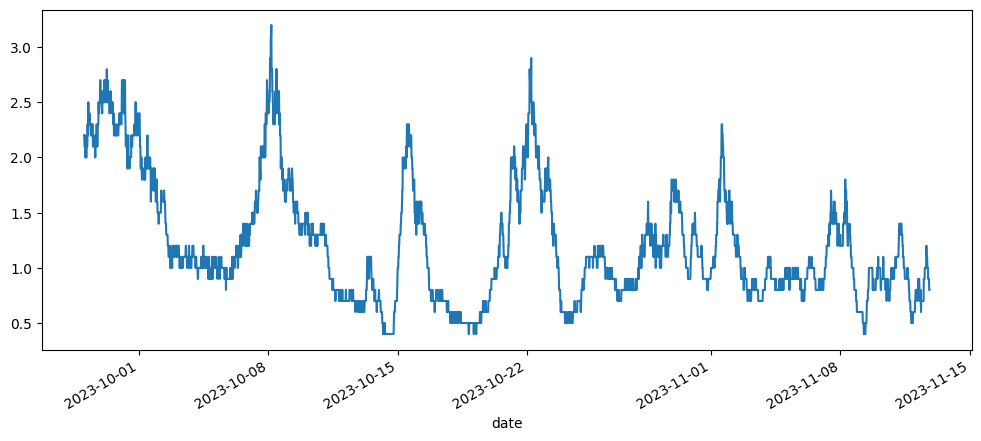

In [29]:
# this is what it looks like to get the standard data for a singular buoy

df_standard = ndbc.get_data("44025", dataset="standard")
print(df_standard.shape)
df_standard.head(2)

df_standard["wave_height"].ffill().plot(figsize=(12,5))

In [34]:
# creating a df for the combined data for all buoys around NY
ny_buoys_standard = pd.DataFrame()

for station_id in ny_station_ids:

    # get the standard data for a singular buoy
    df_station = ndbc.get_data(station_id, dataset="standard")
    
    # Add a column for station ID
    df_station['station_id'] = station_id
    
    # Concatenate the current station's data to the combined DataFrame
    ny_buoys_standard = pd.concat([ny_buoys_standard, df_station], ignore_index=False)


print(ny_buoys_standard.shape)
print(ny_buoys_standard['station_id'].nunique())
ny_buoys_standard.head(2)


(22049, 15)
13


,wind_direction,wind_speed,wind_gust,wave_height,dominant_period,average_period,mean_wave_direction,pressure,air_temp,water_temp,dewpoint,visibility,pressure_tendency,tide,station_id
date,,,,,,,,,,,,,,,
2023-10-03 16:30:00,200.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,21.8,22.6,15.9,NaN,NaN,NaN,44022
2023-10-03 16:45:00,190.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,22.2,22.6,15.8,NaN,NaN,NaN,44022


### Handling missing data

In [40]:
no_wave_count = pd.DataFrame()
for station_id in ny_station_ids:

    filtered_data = ny_buoys_standard[ny_buoys_standard['station_id'] == station_id]

    # Count the number of NaN values in the 'wave_height' column
    nan_count = filtered_data['wave_height'].isna().sum()

    total_rows = len(filtered_data)

    # Append a new row to the no_wave_count DataFrame
    no_wave_count = no_wave_count.append({
        'station_id': station_id,
        'Nan Count (wave_height)': nan_count,
        'Total Rows': total_rows
    }, ignore_index=True)

no_wave_count



,station_id,Nan Count (wave_height),Total Rows
0,44022,3423,3423
1,44025,681,3308
2,44065,3279,6530
3,44069,2025,2025
4,45012,3500,6567
5,45135,22,22
6,45137,0,25
7,45139,4,25
8,45142,19,25
9,45143,0,25


So... there seems to be a pretty significant amount of data missing!
I am just going to remove those rows. 

In [42]:
ny_buoys_standard_cleaned = ny_buoys_standard.dropna(subset=['wave_height'])
print(ny_buoys_standard.shape)
print(ny_buoys_standard_cleaned.shape)

(22049, 15)
(9096, 15)


### Normalize Target Variable


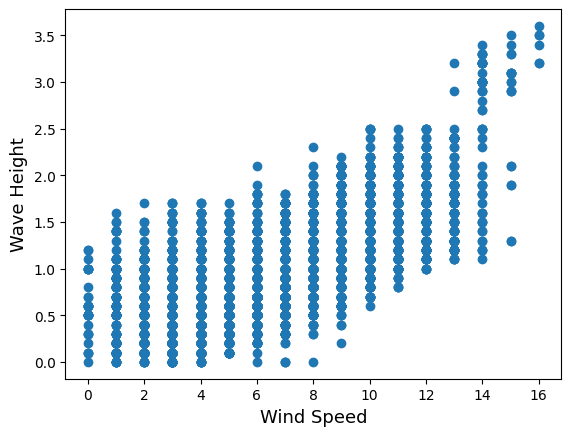

In [48]:
fig, ax = plt.subplots()
ax.scatter(x = ny_buoys_standard_cleaned['wind_speed'], y = ny_buoys_standard_cleaned['wave_height'])
plt.ylabel('Wave Height', fontsize=13)
plt.xlabel('Wind Speed', fontsize=13)
plt.show()


 mu = 0.97 and sigma = 0.55



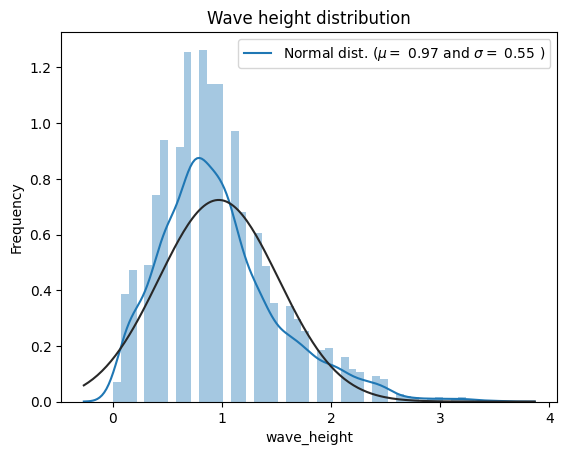

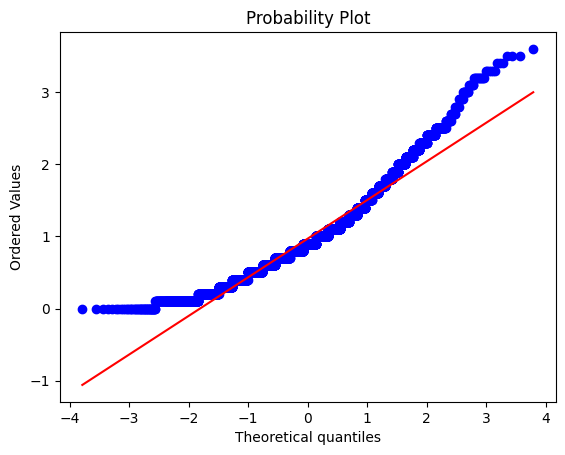

In [44]:
sns.distplot(ny_buoys_standard_cleaned['wave_height'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(ny_buoys_standard_cleaned['wave_height'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# Now plot the distribution
# TODO test with different distributions
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')
plt.ylabel('Frequency')
plt.title('Wave height distribution')

# Get also the QQ-plot
fig = plt.figure()
res = probplot(ny_buoys_standard_cleaned['wave_height'], plot=plt)
plt.show()